In [ ]:
# ! pip install torchaudio

In [ ]:
# ! pip install kaggle

In [ ]:
!pip install torchsummaryX

In [ ]:
!pip install python-levenshtein

     |████████████████████████████████| 50 kB 4.5 MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149872 sha256=84ab6c09720d617c6fe03e01e132d49d59c757ba4ed4dd76dad9e246f3ae9928
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-levenshtein


In [ ]:
import os
import sys
import csv
import math
import pandas as pd
import numpy as np
import Levenshtein as lev
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import FrequencyMasking, TimeMasking
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchsummaryX import summary
from tqdm.auto import tqdm

cuda = torch.cuda.is_available()

print(cuda, sys.version)

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))
np.random.seed(11785)
torch.manual_seed(11785)

# The labels of the dataset contain letters in LETTER_LIST.
# You should use this to convert the letters to the corresponding indices
# and train your model with numerical labels.
LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']

True 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Cuda = True with num_workers = 4


In [ ]:
batch_size = 64

In [ ]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    based on LETTER_LIST

    Args:
        letter_list: LETTER_LIST

    Return:
        letter2index: Dictionary mapping from letters to indices
        index2letter: Dictionary mapping from indices to letters
    '''
    letter2index = dict()
    index2letter = dict()
    for idx, val in enumerate(LETTER_LIST):
        letter2index[val] = idx
        index2letter[idx] = val

    return letter2index, index2letter
    

def transform_index_to_letter(batch_indices):
    '''
    Transforms numerical index input to string output by converting each index 
    to its corresponding letter from LETTER_LIST

    Args:
        batch_indices: List of indices from LETTER_LIST with the shape of (N, )
    
    Return:
        transcripts: List of converted string transcripts. This would be a list with a length of N
    '''
    transcripts = [index2letter[i] for i in batch_indices]   
    return transcripts
        
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [ ]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    based on LETTER_LIST

    Args:
        letter_list: LETTER_LIST

    Return:
        letter2index: Dictionary mapping from letters to indices
        index2letter: Dictionary mapping from indices to letters
    '''
    letter2index = dict()
    index2letter = dict()
    for idx, val in enumerate(LETTER_LIST):
        letter2index[val] = idx
        index2letter[idx] = val

    return letter2index, index2letter
    

def transform_index_to_letter(batch_indices):
    '''
    Transforms numerical index input to string output by converting each index 
    to its corresponding letter from LETTER_LIST

    Args:
        batch_indices: List of indices from LETTER_LIST with the shape of (N, )
    
    Return:
        transcripts: List of converted string transcripts. This would be a list with a length of N
    '''
    transcripts = [index2letter[i] for i in batch_indices]   
    return transcripts
        
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle

Mounted at /content/drive


In [ ]:
! kaggle competitions download -c 11-785-s22-hw4p2

 99% 1.83G/1.84G [00:10<00:00, 225MB/s]
100% 1.84G/1.84G [00:10<00:00, 182MB/s]


In [ ]:
! unzip -q /content/11-785-s22-hw4p2.zip

In [ ]:
def parse_csv(filepath):
    subset = []
    with open(filepath) as f:
        f_csv = csv.reader(f)
        for row in f_csv:
            subset.append(row[0])
    return subset[1:]

In [ ]:
frequency_mask = FrequencyMasking(2)
time_mask = TimeMasking(80)

In [ ]:
class LibriSamples(torch.utils.data.Dataset):

    def __init__(self, data_path, partition= "train"):
        
        self.X_dir = data_path + '/' + partition + '/mfcc/'
        self.Y_dir = data_path + '/' + partition + '/transcript/'

        self.partition = partition

        self.X_files = os.listdir(self.X_dir)
        self.Y_files = os.listdir(self.Y_dir)

        assert(len(self.X_files) == len(self.Y_files))
        
        self.LETTER_LIST = LETTER_LIST

    def __len__(self):
        return len(self.X_files)

    def __getitem__(self, ind):

        X = np.load(self.X_dir + self.X_files[ind])
        Y = np.load(self.Y_dir + self.Y_files[ind])
        Yy = [self.LETTER_LIST.index(yy) for yy in Y]

        return (torch.tensor(X), torch.tensor(Yy, dtype=torch.long))
    
    def collate_fn(self, batch):

        batch_x = [(x - x.mean(axis=0))/x.std(axis=0) for x,y in batch]
        batch_x_pad = pad_sequence(batch_x, batch_first = True)
        lengths_x = [len(x) for x in batch_x]
        
        batch_y = [y for x,y in batch]
        batch_y_pad = pad_sequence(batch_y, batch_first = True)
        lengths_y = [len(y) for y in batch_y]
        
        if self.partition == 'train':
            batch_x_pad = torch.permute(batch_x_pad, (0,2,1))
            batch_x_pad = frequency_mask(batch_x_pad)
            batch_x_pad = time_mask(batch_x_pad)
            batch_x_pad = torch.permute(batch_x_pad, (0,2,1))
        
        return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)
        
class LibriSamplesTest(torch.utils.data.Dataset):

    def __init__(self, data_path, test_order):

        test_order_list = parse_csv('/content/hw4p2_student_data/hw4p2_student_data/test/test_order.csv')
        self.X_path = data_path + '/test/mfcc/'
        self.X = [np.load(self.X_path + file) for file in test_order_list]
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ind):
        return torch.tensor(self.X[ind])
    
    def collate_fn(self, batch):
        batch_x = [(x - x.mean(axis=0))/x.std(axis=0) for x in batch]
        batch_x_pad = pad_sequence(batch_x, batch_first = True)
        lengths_x = [len(x) for x in batch_x]

        return batch_x_pad, torch.tensor(lengths_x)

In [ ]:
root = '/content/hw4p2_student_data/hw4p2_student_data'

train_data = LibriSamples(root, 'train')
val_data = LibriSamples(root, 'dev')
test_data = LibriSamplesTest(root, 'test')

train_loader = DataLoader(train_data, shuffle = True, collate_fn = train_data.collate_fn, batch_size = batch_size)

val_loader = DataLoader(val_data, shuffle = False, collate_fn = train_data.collate_fn, batch_size = batch_size)

test_loader = DataLoader(test_data, shuffle = False, collate_fn = test_data.collate_fn, batch_size = batch_size)


print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  64
Train dataset samples = 28539, batches = 446
Val dataset samples = 2703, batches = 43
Test dataset samples = 2620, batches = 41


In [ ]:
# test code for checking shapes
for data in val_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, len(ly))
    print(y[2]) # desired 
    break

torch.Size([64, 2087, 13]) torch.Size([64, 360]) torch.Size([64]) 64
tensor([ 0, 19,  3,  1, 18,  5,  4, 28,  4,  1,  8, 28, 23,  8, 15, 27, 19, 28,
         1,  6, 18,  1,  9,  4, 28,  1, 14, 19, 23,  5, 18,  5,  4, 28,  8,  5,
        29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [ ]:
class LockedDropout(nn.Module):
    def __init__(self, p=0.5):
        self.p = p
        super().__init__()

    def forward(self, x):
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask

In [ ]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed
    2. Truncate the input length dimension by concatenating feature dimension
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    def __init__(self, input_dim, hidden_dim, pyramidal = True):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, batch_first = True, bidirectional = True, bias = True)
        self.lockdrop = LockedDropout(0.2)
        self.pyramidal = pyramidal
        self.blstm.apply(self._init_weights)

    def _init_weights(self, m):
        for param in m.parameters():
            nn.init.uniform_(param.data, -0.1, 0.1)

    def forward(self, x):

        out, lengths = pad_packed_sequence(x, batch_first = True)

        if self.pyramidal:
            out = out[:, :(out.size(1)-out.size(1)%2),:]
            out = out.contiguous().view(out.size(0), out.size(1)//2, out.size(2)*2)
            out = pack_padded_sequence(out, torch.div(lengths, 2, rounding_mode='floor'), batch_first = True, enforce_sorted = False)
        else:
            out = pack_padded_sequence(out, lengths, batch_first = True, enforce_sorted = False)
        out, _ = self.blstm(out)

        out, lengths = pad_packed_sequence(out, batch_first = True)
        out = torch.permute(out, (1,0,2))
        out = self.lockdrop(out)
        out = torch.permute(out, (1,0,2))

        out = pack_padded_sequence(out, lengths, batch_first = True, enforce_sorted = False)
        
        return out
        

In [ ]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.

    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        # The first LSTM layer at the bottom
        self.lstm = nn.LSTM(input_size = 13, hidden_size = encoder_hidden_dim, bidirectional = True, 
                            num_layers = 1, bias = True, batch_first = True)
        self.lstm.apply(self._init_weights)
        # Define the blocks of pBLSTMs
        # Dimensions should be chosen carefully
        # Hint: Bidirectionality, truncation...

        self.pBLSTMs = nn.Sequential(
            pBLSTM(input_dim = encoder_hidden_dim * 4,
                   hidden_dim = encoder_hidden_dim),
            
            pBLSTM(input_dim = encoder_hidden_dim * 4,
                   hidden_dim = encoder_hidden_dim),
            
            pBLSTM(input_dim = encoder_hidden_dim * 4,
                   hidden_dim = encoder_hidden_dim),
        )

        # The linear transformations for producing Key and Value for attention
        # Hint: Dimensions when bidirectional lstm? 
        self.key_network = nn.Linear(encoder_hidden_dim*2, key_value_size)
        self.value_network = nn.Linear(encoder_hidden_dim*2, key_value_size)

    
    def _init_weights(self, m):
        for param in m.parameters():
            nn.init.uniform_(param.data, -0.1, 0.1)
    
    def forward(self, x, x_len):
        """
        1. Pack your input and pass it through the first LSTM layer (no truncation)
        2. Pass it through the pyramidal LSTM layer
        3. Pad your input back to (B, T, *) or (T, B, *) shape
        4. Output Key, Value, and truncated input lens

        Key and value could be
            (i) Concatenated hidden vectors from all time steps (key == value).
            (ii) Linear projections of the output from the last pBLSTM network.
                If you choose this way, you can use the final output of
                your pBLSTM network.
        """

        out = pack_padded_sequence(x, lengths = x_len, enforce_sorted=False, batch_first = True)

        out, _ = self.lstm(out)
        out = self.pBLSTMs(out)
        out, lx = pad_packed_sequence(out, batch_first = True)

        key = self.key_network(out)
        value = self.value_network(out)

        return key, value, lx

In [ ]:
def plot_attention(attention):
    # utility function for debugging
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key and value from encoder and query from decoder.
    Here are different ways to compute attention and context:
    1. Dot-product attention
        energy = bmm(key, query) 
        # Optional: Scaled dot-product by normalizing with sqrt key dimension
        # Check "attention is all you need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore...
    2. Cosine attention
        energy = cosine(query, key) # almost the same as dot-product xD 
    3. Bi-linear attention
        W = Linear transformation (learnable parameter): d_k -> d_q
        energy = bmm(key @ W, query)
    4. Multi-layer perceptron
        # Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4
    
    After obtaining unnormalized attention weights (energy), compute and return attention and context, i.e.,
    energy = mask(energy) # mask out padded elements with big negative number (e.g. -1e9)
    attention = softmax(energy)
    context = bmm(attention, value)

    5. Multi-Head Attention
        # Check "attention is all you need" Section 3.2.2
        h = Number of heads
        W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
        W_O: d_v -> d_v

        Reshape K: (B, T, d_k)
        to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
        Reshape V: (B, T, d_v)
        to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
        Reshape Q: (B, d_q)
        to (B, h, d_q // h)

        energy = Q @ K^T
        energy = mask(energy)
        attention = softmax(energy)
        multi_head = attention @ V
        multi_head = multi_head reshaped to (B, d_v)
        context = multi_head @ W_O
    '''
    def __init__(self, heads, key_value_size):
        super(Attention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.h = heads
        self.fc = nn.Linear(key_value_size, key_value_size)

    def forward(self, query, key, value, mask):
        """
        input:
            key: (batch_size, seq_len, d_k)
            value: (batch_size, seq_len, d_v)
            query: (batch_size, d_q)
        * Hint: d_k == d_v == d_q is often true if you use linear projections
        return:
            context: (batch_size, key_val_dim)
        
        """

        # Reshape K: (B, T, d_k)
        # to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
        # Reshape V: (B, T, d_v)
        # to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
        # Reshape Q: (B, d_q)
        # to (B, h, d_q // h)

        # B, T, d_k = key.size()
        # B, T, d_v = value.size()
        # B, d_q = query.size()

        # key = key.reshape(B, T, self.h, d_k // self.h)
        # key = key.transpose(1,2)

        # value = value.reshape(B, T, self.h, d_v // self.h)
        # value = value.transpose(1,2)

        # query = query.reshape(B, self.h, d_q // self.h)

        # energy = torch.matmul(query.unsqueeze(2), key.transpose(2,3)).squeeze(2)
        
        # energy.masked_fill_(mask, -1e9)
        # attention = self.softmax(energy)

        # multihead = torch.matmul(attention.unsqueeze(2), value).squeeze(2)
        # multihead = multihead.reshape(B, d_v)

        energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2)
        energy.masked_fill_(mask, float('-inf'))
        attention = self.softmax(energy)

        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)
        context = self.fc(context)
        return context, attention
        # we return attention weights for plotting (for debugging)

In [ ]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the last LSTMCell can be used as a query for calculating attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128, heads = 4):
        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = len(LETTER_LIST)-1)
        self.heads = heads

        self.lstm1 = nn.LSTMCell(input_size = embed_dim + key_value_size, hidden_size = decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size = decoder_hidden_dim, hidden_size = decoder_hidden_dim)
        self.lstm3 = nn.LSTMCell(input_size = decoder_hidden_dim, hidden_size = key_value_size)

        self.lockDrop1 = LockedDropout(0.2)
        self.lockDrop2 = LockedDropout(0.2)
        self.lockDrop3 = LockedDropout(0.2)

        self.query_network = nn.Linear(key_value_size, key_value_size)
        
        self.attention = Attention(heads, key_value_size)   
        self.vocab_size = vocab_size
        
        self.character_prob = nn.Linear(2 * key_value_size, vocab_size) #: d_v -> vocab_size
        self.key_value_size = key_value_size
        
        self.character_prob.weight = self.embedding.weight

    
    def _init_weights(self, m):
        for param in m.parameters():
            nn.init.uniform_(param.data, -0.1, 0.1)
    
    def forward(self, key, value, encoder_len, y=None, mode='train'):
        '''
        Args:
            key :(B, T, d_k) - Output of the Encoder (possibly from the Key projection layer)
            value: (B, T, d_v) - Output of the Encoder (possibly from the Value projection layer)
            y: (B, text_len) - Batch input of text with text_length
            mode: Train or eval mode for teacher forcing
        Return:
            predictions: the character perdiction probability 
        '''

        B, key_seq_max_len, key_value_size = key.shape
    
        if mode == 'train' or mode == 'validation':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y)
        else:
            max_len = 600
        
        # TODO: Create the attention mask here (outside the for loop rather than inside) to aviod repetition
        
        mask = torch.arange(key_seq_max_len).unsqueeze(0)
        mask = mask >= encoder_len.unsqueeze(1)
        mask = mask.to(device)
        
        predictions = []
        prediction = torch.zeros(size = (B,), dtype = torch.long).to(device)

        hidden_states = [None, None, None]
        
        context = value[:,0,:]

        attention_plot = [] 

        for i in range(max_len):
            first = torch.zeros(size = (B,), dtype = torch.long)
            if mode == 'train':

                isTeacherForcing = True if random.random() > (1 - teacherForcing) else False

                if isTeacherForcing:
                    if i == 0:
                        first = first.fill_(letter2index['<sos>']).to(device)
                        char_embed = self.embedding(first)

                    else:
                        char_embed = char_embeddings[:, i-1, :]

                else:
                    if i != 0:
                        char_embed = self.embedding(prediction.argmax(dim=-1))
                    else:
                        first = first.fill_(letter2index['<sos>']).to(device)
                        char_embed = self.embedding(first)

            else:
                if i == 0:
                    first = first.fill_(letter2index['<sos>']).to(device)
                    char_embed = self.embedding(first)
                else:
                    char_embed = self.embedding(prediction.argmax(dim=-1))

            # what vectors should be concatenated as a context?
            y_context = torch.cat([char_embed, context], dim=1)

            hidden_states[0] = self.lstm1(y_context, hidden_states[0])
            hidden_states[0] = (self.lockDrop1(hidden_states[0][0].unsqueeze(0)).squeeze(0), hidden_states[0][1])

            hidden_states[1] = self.lstm2(hidden_states[0][0], hidden_states[1])
            hidden_states[1] = (self.lockDrop2(hidden_states[1][0].unsqueeze(0)).squeeze(0), hidden_states[1][1])        

            hidden_states[2] = self.lstm3(hidden_states[1][0], hidden_states[2])
            hidden_states[2] = (self.lockDrop3(hidden_states[2][0].unsqueeze(0)).squeeze(0), hidden_states[2][1])

            query = hidden_states[2][0]
            query = self.query_network(query)

            context, attention = self.attention(query, key, value, mask)

            attention_plot.append(attention[0].detach().cpu())

            output_context = torch.cat([query, context], dim=1)
            prediction = self.character_prob(output_context)

            predictions.append(prediction.unsqueeze(1))
        
        # Concatenate the attention and predictions to return
        attentions = torch.stack(attention_plot, dim=0)
        predictions = torch.cat(predictions, dim=1)
        return predictions, attentions

In [ ]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128, heads = 4):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size, heads)

    def forward(self, x, x_len, y=None, mode='train'):
        key, value, encoder_len = self.encoder(x, x_len)
        predictions, attentions = self.decoder(key, value, encoder_len, y=y, mode=mode)
        return predictions, attentions

In [ ]:
model = Seq2Seq(13, len(LETTER_LIST), encoder_hidden_dim = 512, decoder_hidden_dim = 512, 
                embed_dim = 512, key_value_size = 256, heads = 1)

model = model.to(device)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode='min', factor = 0.5, patience = 5, threshold = 0.1)
criterion = nn.CrossEntropyLoss(reduction='none')
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def calculateLev(prediction, target):

    dist = 0
    for item in range(len(prediction)):
        
        pred = prediction[item]
        targ = target[item]

        predictionTokens = []
        for token in pred:
            if token == 0:
                continue
            elif token == 29:
                break
            predictionTokens.append(token)

        targetTokens = []
        for token in targ:
            if token == 0:
                continue
            elif token == 29:
                break
            targetTokens.append(token)

        predictedString = "".join(transform_index_to_letter(predictionTokens))
        targetString = "".join(transform_index_to_letter(targetTokens))

        dist += lev.distance(predictedString, targetString)

    return dist

In [ ]:
def train(epoch, model, train_loader, criterion, optimizer, mode):
    model.train()
    total_loss = 0
    
    for i, (x, y, x_len, y_len) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)


        with torch.cuda.amp.autocast():
            predictions, attentions = model(x, x_len, y, mode=mode)

            mask_length = torch.max(y_len)
            mask = torch.arange(0, mask_length).repeat(y.size(0), 1)
            mask = mask < y_len.unsqueeze(1).expand(y_len.size(0), mask_length).int()
            mask = mask.to(device)

            
            loss = criterion(predictions.view(-1, predictions.size(2)), y.view(-1))

            masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
            total_loss += masked_loss.detach()
            
            del loss, x, y, mask

        
            scaler.scale(masked_loss).backward() 
            scaler.step(optimizer) 
            scaler.update()

    print('Training Loss: ', total_loss/len(train_loader))
    plot_attention(attentions)
        
def val(model, valid_loader):
    model.eval()
    total_loss = 0
    distance = 0
    with torch.no_grad():

        for i, (x, y, x_len, y_len) in enumerate(valid_loader):

            x = x.to(device)
            y = y.to(device)
            
            predictions, attentions = model(x, x_len, y, mode = 'validation')

            mask_length = torch.max(y_len)
            mask = torch.arange(0, mask_length).repeat(y.size(0), 1)
            mask = mask < y_len.unsqueeze(1).expand(y_len.size(0), mask_length).int()
            mask = mask.to(device)

            loss = criterion(predictions.view(-1, predictions.size(2)), y.view(-1))
            masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
            total_loss += masked_loss.detach()

            predText = predictions.argmax(-1).detach().cpu().numpy()
            targetText = y.detach().cpu().numpy()

            distance += (calculateLev(predText, targetText))/x.shape[0]
            
        loss = total_loss / len(valid_loader)
        distance = distance / len(valid_loader)
        print('Validation Loss: ', loss)
        print('Validation Distance: ', distance)

        return distance

In [ ]:
teacherForcing = 1

Epoch:  1


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(2.0654, device='cuda:0')


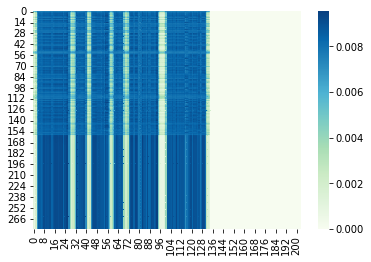

Validation Loss:  tensor(5.7906, device='cuda:0')
Validation Distance:  297.90072674418604
Teacher forcing rate 1
Epoch:  2


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.3294, device='cuda:0')


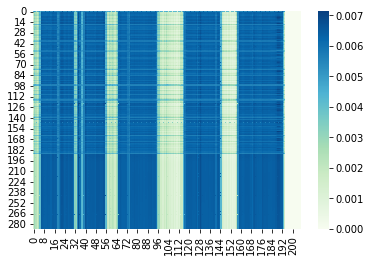

Validation Loss:  tensor(6.4467, device='cuda:0')
Validation Distance:  292.6097868217054
Teacher forcing rate 1
Epoch:  3


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.2444, device='cuda:0')


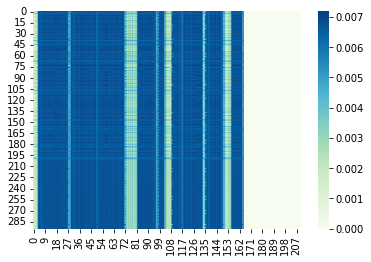

Validation Loss:  tensor(6.3478, device='cuda:0')
Validation Distance:  288.95564437984495
Teacher forcing rate 1
Epoch:  4


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.1994, device='cuda:0')


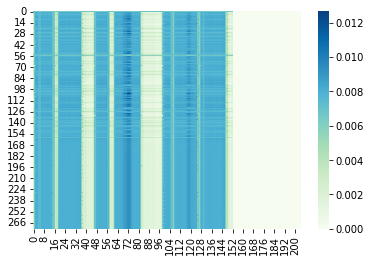

Validation Loss:  tensor(6.2807, device='cuda:0')
Validation Distance:  297.5694040697674
Teacher forcing rate 1
Epoch:  5


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.1670, device='cuda:0')


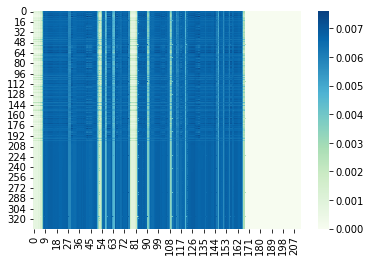

Validation Loss:  tensor(6.6762, device='cuda:0')
Validation Distance:  291.4702277131783
Teacher forcing rate 1
Epoch:  6


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.1421, device='cuda:0')


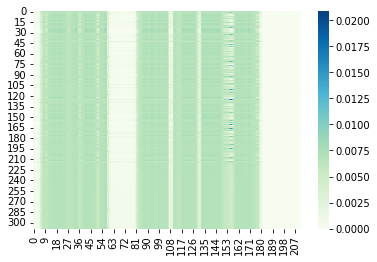

Validation Loss:  tensor(6.7094, device='cuda:0')
Validation Distance:  291.69874031007754
Teacher forcing rate 1
Epoch:  7


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.1215, device='cuda:0')


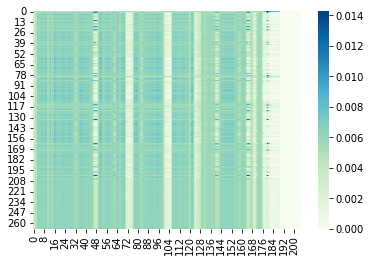

Validation Loss:  tensor(7.0726, device='cuda:0')
Validation Distance:  292.80850290697674
Teacher forcing rate 1
Epoch:  8


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.1027, device='cuda:0')


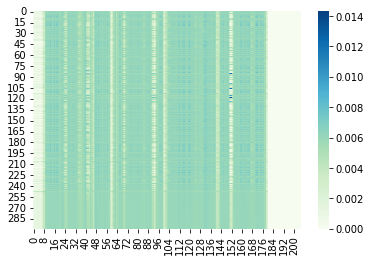

Validation Loss:  tensor(7.0771, device='cuda:0')
Validation Distance:  293.51327519379845
Teacher forcing rate 1
Epoch:  9


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.0859, device='cuda:0')


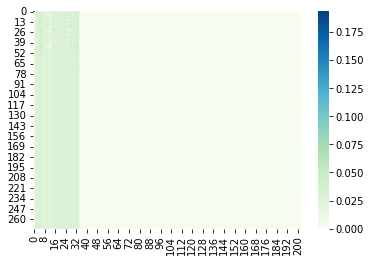

Validation Loss:  tensor(6.9905, device='cuda:0')
Validation Distance:  292.6004360465116
Teacher forcing rate 1
Epoch:  10


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.0653, device='cuda:0')


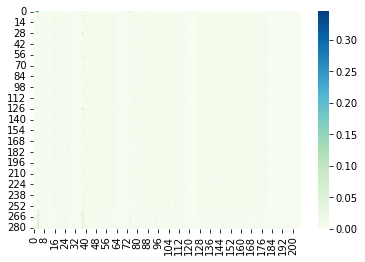

Validation Loss:  tensor(7.1455, device='cuda:0')
Validation Distance:  292.52245639534885
Teacher forcing rate 1
Epoch:  11


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(1.0189, device='cuda:0')


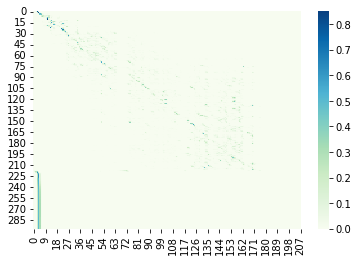

Validation Loss:  tensor(7.3422, device='cuda:0')
Validation Distance:  220.3451792635659
Teacher forcing rate 1
Epoch:  12


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.5144, device='cuda:0')


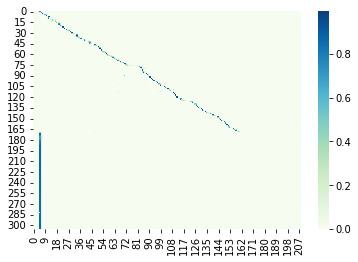

Validation Loss:  tensor(8.5547, device='cuda:0')
Validation Distance:  48.33478682170543
Teacher forcing rate 1
Epoch:  13


  0%|          | 0/446 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
n_epochs = 80
mode = 'train'
epoch = 0
distance = 500
for epoch in range(epoch, n_epochs):
    print('Epoch: ', epoch+1)
    
    train(epoch, model, train_loader, criterion, optimizer, mode)
    distance = val(model, val_loader)

    print('Teacher forcing rate', teacherForcing)

    if distance < 20:
        scheduler.step(distance)
        print(scheduler._last_lr)
        if teacherForcing > 0.5:
            teacherForcing -= 0.02

    elif distance <= 50 and distance >= 20:
        teacherForcing -= 0.05

    elif distance >= 50 and distance <= 100:
        teacherForcing = 0.95

    if epoch % 5 == 0:
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': scheduler
        }
        torch.save(checkpoint, '/content/drive/MyDrive/hw4p2/checkpoint'+str(epoch)+'.pth')

Epoch:  14


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.2797, device='cuda:0')


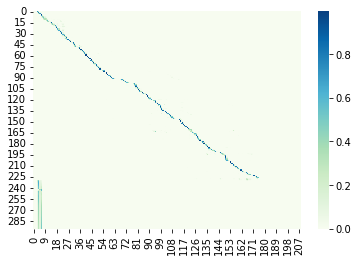

Validation Loss:  tensor(7.4957, device='cuda:0')
Validation Distance:  33.57827034883721
Teacher forcing rate 0.95
Epoch:  15


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.2417, device='cuda:0')


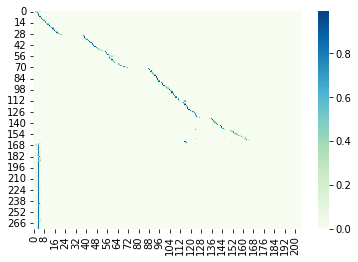

Validation Loss:  tensor(7.1446, device='cuda:0')
Validation Distance:  23.131734496124032
Teacher forcing rate 0.8999999999999999
Epoch:  16


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.2187, device='cuda:0')


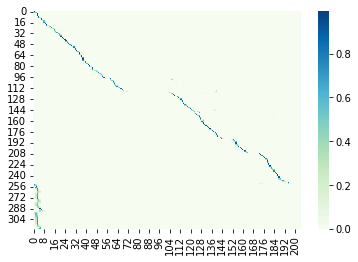

Validation Loss:  tensor(6.4783, device='cuda:0')
Validation Distance:  20.519428294573643
Teacher forcing rate 0.8499999999999999
Epoch:  17


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.2220, device='cuda:0')


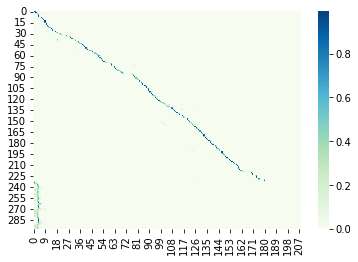

Validation Loss:  tensor(6.4483, device='cuda:0')
Validation Distance:  17.83529554263566
Teacher forcing rate 0.7999999999999998
[0.001]
Epoch:  18


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1958, device='cuda:0')


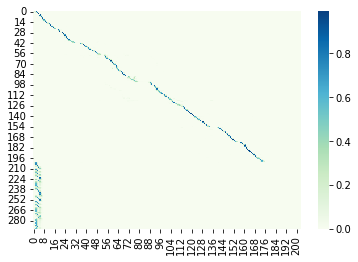

Validation Loss:  tensor(6.1099, device='cuda:0')
Validation Distance:  16.185537790697673
Teacher forcing rate 0.7699999999999998
[0.001]
Epoch:  19


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1825, device='cuda:0')


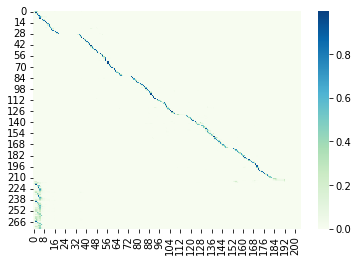

Validation Loss:  tensor(6.1031, device='cuda:0')
Validation Distance:  14.788953488372092
Teacher forcing rate 0.7399999999999998
[0.001]
Epoch:  20


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1731, device='cuda:0')


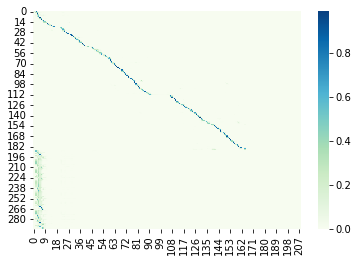

Validation Loss:  tensor(6.0295, device='cuda:0')
Validation Distance:  13.99205426356589
Teacher forcing rate 0.7099999999999997
[0.001]
Epoch:  21


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1669, device='cuda:0')


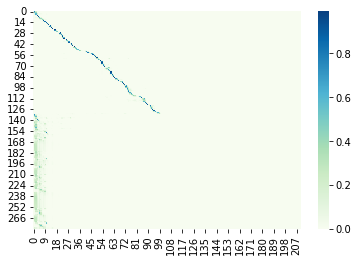

Validation Loss:  tensor(5.9359, device='cuda:0')
Validation Distance:  13.845106589147285
Teacher forcing rate 0.6799999999999997
[0.001]
Epoch:  22


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1655, device='cuda:0')


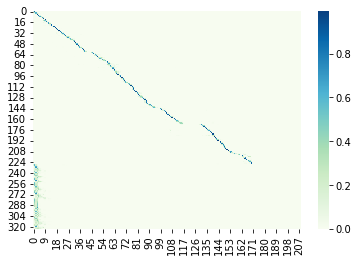

Validation Loss:  tensor(5.9218, device='cuda:0')
Validation Distance:  13.231928294573645
Teacher forcing rate 0.6499999999999997
[0.001]
Epoch:  23


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1603, device='cuda:0')


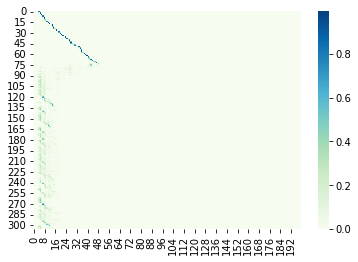

Validation Loss:  tensor(5.8488, device='cuda:0')
Validation Distance:  12.672044573643412
Teacher forcing rate 0.6199999999999997
[0.001]
Epoch:  24


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1591, device='cuda:0')


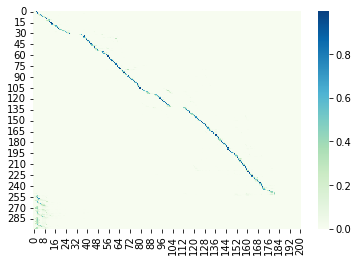

Validation Loss:  tensor(5.7567, device='cuda:0')
Validation Distance:  12.705741279069766
Teacher forcing rate 0.5899999999999996
[0.001]
Epoch:  25


  0%|          | 0/446 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
n_epochs = 50
mode = 'train'
epoch = 13
for epoch in range(epoch, n_epochs):
    print('Epoch: ', epoch+1)
    
    train(epoch, model, train_loader, criterion, optimizer, mode)
    distance = val(model, val_loader)

    print('Teacher forcing rate', teacherForcing)

    if distance < 20:
        scheduler.step(distance)
        print(scheduler._last_lr)
        if teacherForcing > 0.5:
            teacherForcing -= 0.03

    elif distance <= 50 and distance >= 20:
        teacherForcing -= 0.05

    elif distance >= 50 and distance <= 100:
        teacherForcing = 0.9

    if epoch >= 10 and epoch % 5 == 0:
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': scheduler
        }
        torch.save(checkpoint, './checkpoint'+str(epoch)+'.pth')

Epoch:  25


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.3550, device='cuda:0')


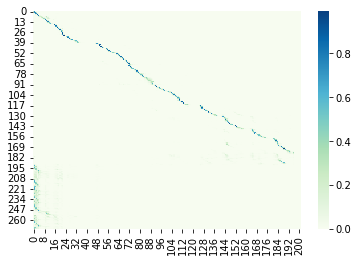

Validation Loss:  tensor(5.5039, device='cuda:0')
Validation Distance:  15.881056201550386
Teacher forcing rate 0.6
[0.001]
Epoch:  26


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.2602, device='cuda:0')


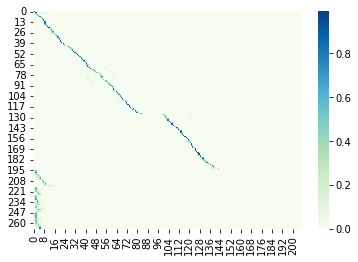

Validation Loss:  tensor(5.5953, device='cuda:0')
Validation Distance:  13.525242248062016
Teacher forcing rate 0.6
[0.001]
Epoch:  27


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.2428, device='cuda:0')


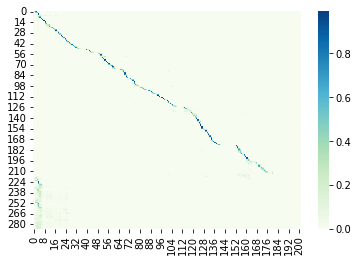

Validation Loss:  tensor(5.5637, device='cuda:0')
Validation Distance:  14.109132751937985
Teacher forcing rate 0.6
[0.001]
Epoch:  28


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.2287, device='cuda:0')


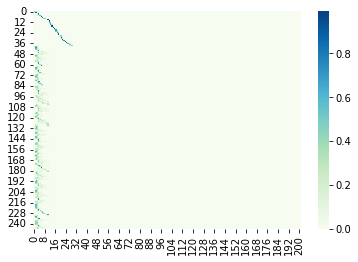

Validation Loss:  tensor(5.8571, device='cuda:0')
Validation Distance:  14.231274224806201
Teacher forcing rate 0.6
[0.0005]
Epoch:  29


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1741, device='cuda:0')


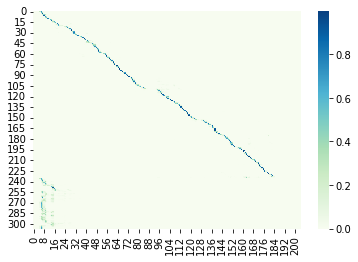

Validation Loss:  tensor(5.9652, device='cuda:0')
Validation Distance:  12.60966569767442
Teacher forcing rate 0.6
[0.0005]
Epoch:  30


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1561, device='cuda:0')


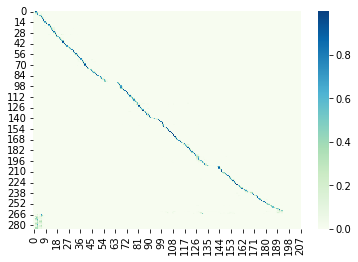

Validation Loss:  tensor(5.8311, device='cuda:0')
Validation Distance:  11.74905523255814
Teacher forcing rate 0.57
[0.0005]
Epoch:  31


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1653, device='cuda:0')


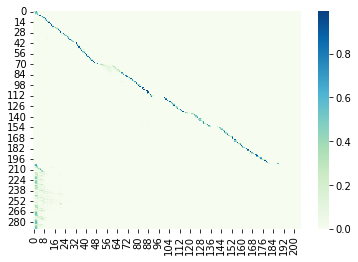

Validation Loss:  tensor(6.0337, device='cuda:0')
Validation Distance:  12.273982558139535
Teacher forcing rate 0.5399999999999999
[0.0005]
Epoch:  32


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1673, device='cuda:0')


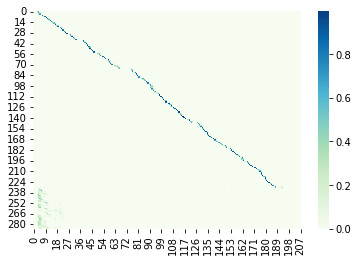

Validation Loss:  tensor(5.8732, device='cuda:0')
Validation Distance:  11.943192829457363
Teacher forcing rate 0.5399999999999999
[0.0005]
Epoch:  33


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1563, device='cuda:0')


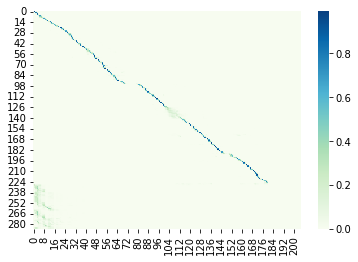

Validation Loss:  tensor(5.9529, device='cuda:0')
Validation Distance:  11.427277131782946
Teacher forcing rate 0.5399999999999999
[0.0005]
Epoch:  34


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1625, device='cuda:0')


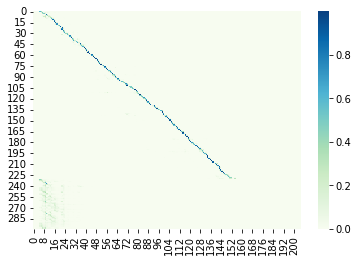

Validation Loss:  tensor(5.7735, device='cuda:0')
Validation Distance:  11.0062257751938
Teacher forcing rate 0.5099999999999999
[0.0005]
Epoch:  35


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1672, device='cuda:0')


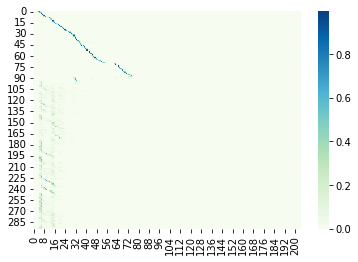

Validation Loss:  tensor(5.8122, device='cuda:0')
Validation Distance:  11.00702519379845
Teacher forcing rate 0.47999999999999987
[0.0005]
Epoch:  36


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1610, device='cuda:0')


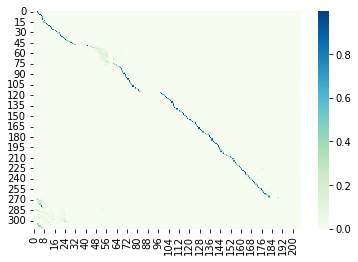

Validation Loss:  tensor(5.3265, device='cuda:0')
Validation Distance:  10.910804263565892
Teacher forcing rate 0.47999999999999987
[0.00025]
Epoch:  37


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1436, device='cuda:0')


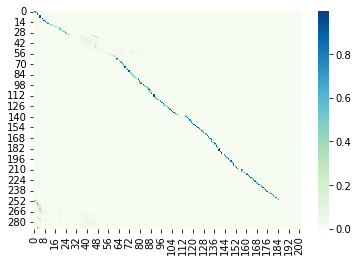

Validation Loss:  tensor(5.6453, device='cuda:0')
Validation Distance:  10.477543604651164
Teacher forcing rate 0.47999999999999987
[0.00025]
Epoch:  38


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1315, device='cuda:0')


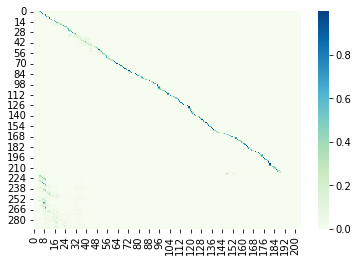

Validation Loss:  tensor(6.3260, device='cuda:0')
Validation Distance:  11.373376937984496
Teacher forcing rate 0.47999999999999987
[0.00025]
Epoch:  39


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1276, device='cuda:0')


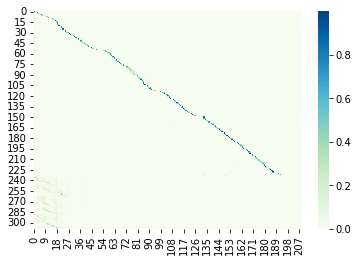

Validation Loss:  tensor(6.1974, device='cuda:0')
Validation Distance:  10.628003875968993
Teacher forcing rate 0.47999999999999987
[0.00025]
Epoch:  40


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1222, device='cuda:0')


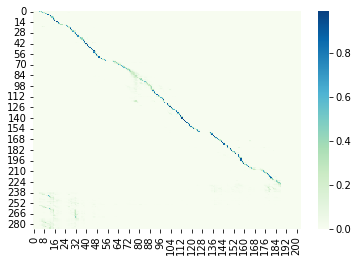

Validation Loss:  tensor(6.1505, device='cuda:0')
Validation Distance:  11.124709302325583
Teacher forcing rate 0.47999999999999987
[0.00025]
Epoch:  41


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1240, device='cuda:0')


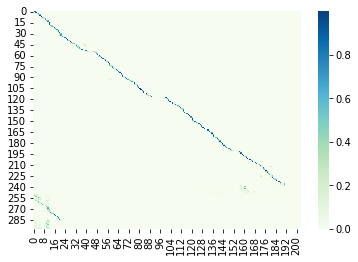

Validation Loss:  tensor(6.2925, device='cuda:0')
Validation Distance:  10.086143410852713
Teacher forcing rate 0.47999999999999987
[0.00025]
Epoch:  42


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1236, device='cuda:0')


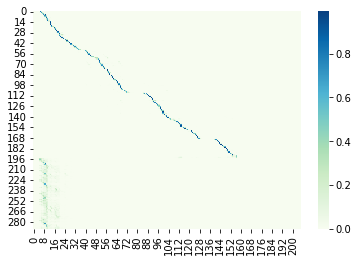

Validation Loss:  tensor(6.2754, device='cuda:0')
Validation Distance:  10.41984011627907
Teacher forcing rate 0.47999999999999987
[0.00025]
Epoch:  43


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1214, device='cuda:0')


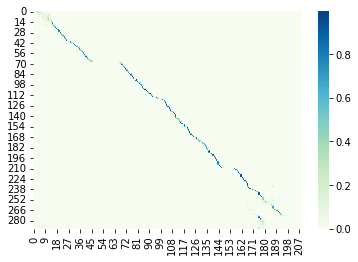

Validation Loss:  tensor(6.2778, device='cuda:0')
Validation Distance:  10.381904069767442
Teacher forcing rate 0.47999999999999987
[0.000125]
Epoch:  44


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1125, device='cuda:0')


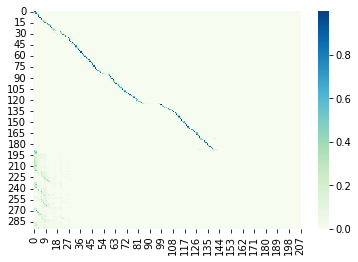

Validation Loss:  tensor(6.3005, device='cuda:0')
Validation Distance:  10.459132751937984
Teacher forcing rate 0.47999999999999987
[0.000125]
Epoch:  45


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1074, device='cuda:0')


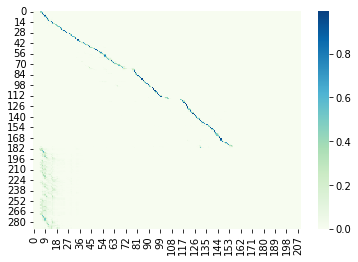

Validation Loss:  tensor(6.3778, device='cuda:0')
Validation Distance:  9.240794573643411
Teacher forcing rate 0.47999999999999987
[0.000125]
Epoch:  46


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1046, device='cuda:0')


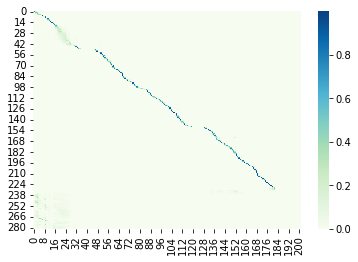

Validation Loss:  tensor(6.5359, device='cuda:0')
Validation Distance:  10.42766472868217
Teacher forcing rate 0.47999999999999987
[0.000125]
Epoch:  47


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1068, device='cuda:0')


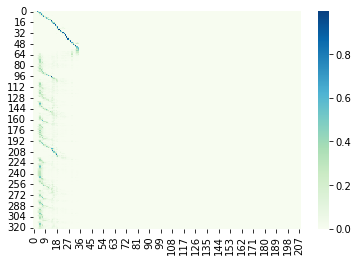

Validation Loss:  tensor(6.2725, device='cuda:0')
Validation Distance:  9.86577034883721
Teacher forcing rate 0.47999999999999987
[0.000125]
Epoch:  48


  0%|          | 0/446 [00:00<?, ?it/s]

In [ ]:
n_epochs = 50
mode = 'train'
epoch = 24
teacherForcing = 0.6
prev_distance = 12.70
for epoch in range(epoch, n_epochs):
    print('Epoch: ', epoch+1)
    
    train(epoch, model, train_loader, criterion, optimizer, mode)
    distance = val(model, val_loader)

    print('Teacher forcing rate', teacherForcing)

    if distance < 20:
        scheduler.step(distance)
        print(scheduler._last_lr)
        if teacherForcing > 0.5:
            if prev_distance > distance:
                teacherForcing -= 0.03
                prev_distance = distance

    elif distance <= 50 and distance >= 20:
        teacherForcing -= 0.05

    elif distance >= 50 and distance <= 100:
        teacherForcing = 0.9

    if epoch >= 10 and epoch % 5 == 0:
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': scheduler
        }
        torch.save(checkpoint, './checkpoint'+str(epoch)+'.pth')

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/hw4p2-alpha/checkpoint45.pth')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler = checkpoint['lr_sched']

In [ ]:
prev_distance = distance

In [ ]:
teacherForcing = 0.65

Epoch:  46


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1509, device='cuda:0')


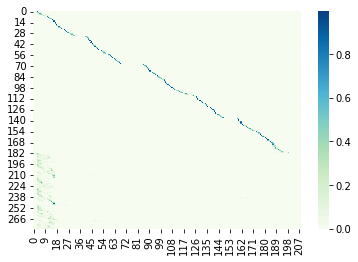

Validation Loss:  tensor(6.3661, device='cuda:0')
Validation Distance:  9.541593992248062
Teacher forcing rate 0.65
[6.25e-05]
Epoch:  47


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1457, device='cuda:0')


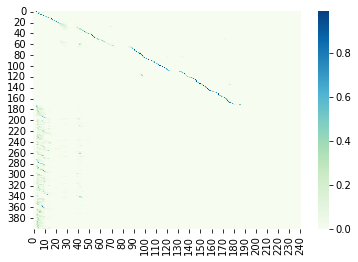

Validation Loss:  tensor(6.6157, device='cuda:0')
Validation Distance:  9.262524224806201
Teacher forcing rate 0.65
[6.25e-05]
Epoch:  48


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1535, device='cuda:0')


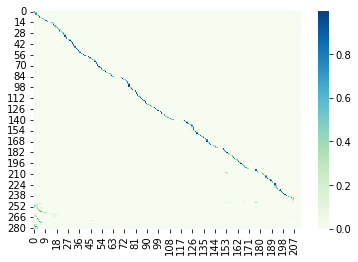

Validation Loss:  tensor(6.6450, device='cuda:0')
Validation Distance:  9.650266472868218
Teacher forcing rate 0.62
[6.25e-05]
Epoch:  49


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1471, device='cuda:0')


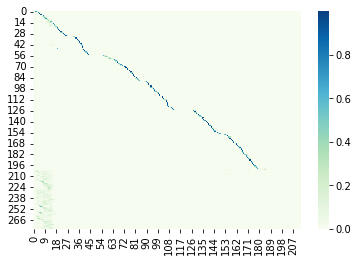

Validation Loss:  tensor(6.6963, device='cuda:0')
Validation Distance:  9.687911821705427
Teacher forcing rate 0.62
[6.25e-05]
Epoch:  50


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1428, device='cuda:0')


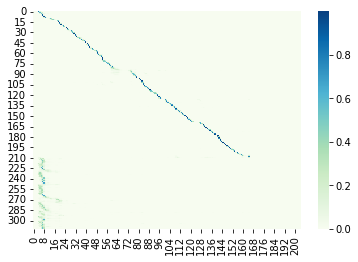

Validation Loss:  tensor(6.6912, device='cuda:0')
Validation Distance:  9.74312015503876
Teacher forcing rate 0.62
[6.25e-05]
Epoch:  51


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1402, device='cuda:0')


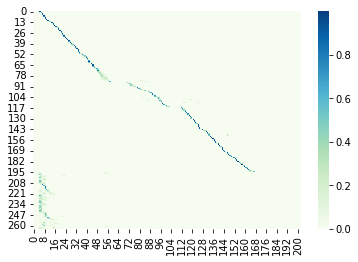

Validation Loss:  tensor(6.5809, device='cuda:0')
Validation Distance:  9.387524224806201
Teacher forcing rate 0.62
[3.125e-05]
Epoch:  52


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1356, device='cuda:0')


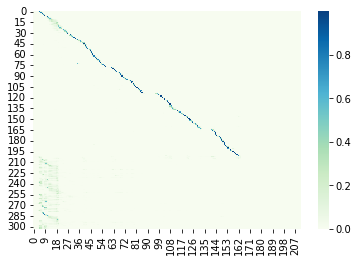

Validation Loss:  tensor(6.8754, device='cuda:0')
Validation Distance:  10.017684108527133
Teacher forcing rate 0.62
[3.125e-05]
Epoch:  53


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1359, device='cuda:0')


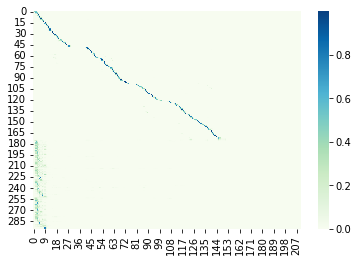

Validation Loss:  tensor(6.7676, device='cuda:0')
Validation Distance:  9.430232558139535
Teacher forcing rate 0.62
[3.125e-05]
Epoch:  54


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1399, device='cuda:0')


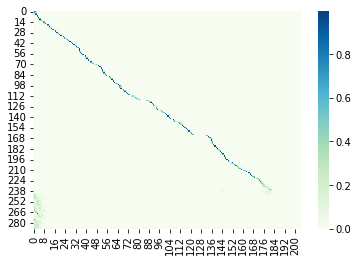

Validation Loss:  tensor(6.8263, device='cuda:0')
Validation Distance:  9.408478682170543
Teacher forcing rate 0.62
[3.125e-05]
Epoch:  55


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1311, device='cuda:0')


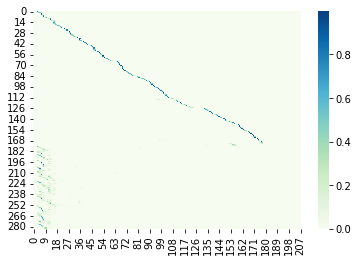

Validation Loss:  tensor(6.7730, device='cuda:0')
Validation Distance:  9.055523255813954
Teacher forcing rate 0.62
[3.125e-05]
Epoch:  56


  0%|          | 0/446 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
epoch = checkpoint['epoch']
n_epochs = epoch + 40
for epoch in range(epoch, n_epochs):
    print('Epoch: ', epoch+1)
    
    train(epoch, model, train_loader, criterion, optimizer, 'train')
    distance = val(model, val_loader)

    print('Teacher forcing rate', teacherForcing)

    if distance < 20:
        scheduler.step(distance)
        print(scheduler._last_lr)
        if teacherForcing > 0.5:
            if prev_distance > distance:
                teacherForcing -= 0.03
                prev_distance = distance

    elif distance <= 50 and distance >= 20:
        teacherForcing -= 0.05

    elif distance >= 50 and distance <= 100:
        teacherForcing = 0.9

    if epoch >= 10 and epoch % 5 == 0:
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': scheduler
        }
        torch.save(checkpoint, './checkpoint'+str(epoch)+'.pth')

In [ ]:
checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': scheduler
        }
torch.save(checkpoint, './checkpoint'+str(epoch)+'.pth')

Epoch:  56


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1423, device='cuda:0')


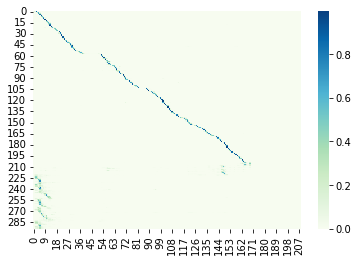

Validation Loss:  tensor(6.6213, device='cuda:0')
Validation Distance:  9.433478682170543
Teacher forcing rate 0.59
[3.125e-05]
Epoch:  57


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1371, device='cuda:0')


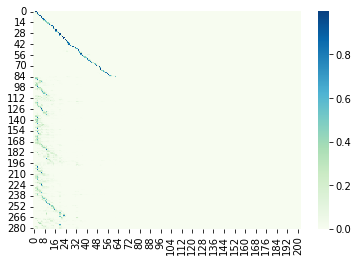

Validation Loss:  tensor(6.7479, device='cuda:0')
Validation Distance:  9.428803294573642
Teacher forcing rate 0.59
[1.5625e-05]
Epoch:  58


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1401, device='cuda:0')


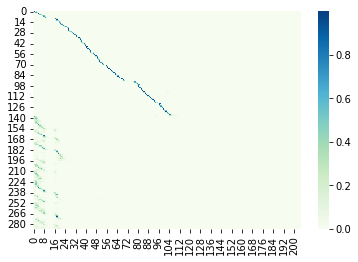

Validation Loss:  tensor(6.5157, device='cuda:0')
Validation Distance:  8.582558139534884
Teacher forcing rate 0.59
[1.5625e-05]
Epoch:  59


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.1470, device='cuda:0')


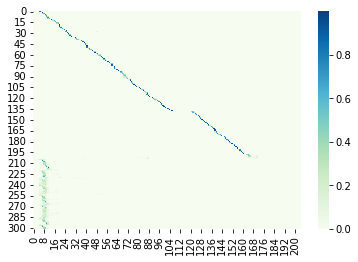

Validation Loss:  tensor(6.6763, device='cuda:0')
Validation Distance:  9.503803294573643
Teacher forcing rate 0.5599999999999999
[1.5625e-05]
Epoch:  60


  0%|          | 0/446 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
epoch = checkpoint['epoch']
n_epochs = epoch + 40
for epoch in range(epoch, n_epochs):
    print('Epoch: ', epoch+1)
    
    train(epoch, model, train_loader, criterion, optimizer, 'train')
    distance = val(model, val_loader)

    print('Teacher forcing rate', teacherForcing)

    if distance < 20:
        scheduler.step(distance)
        print(scheduler._last_lr)
        if teacherForcing > 0.5:
            if prev_distance > distance:
                teacherForcing -= 0.03
                prev_distance = distance

    elif distance <= 50 and distance >= 20:
        teacherForcing -= 0.05

    elif distance >= 50 and distance <= 100:
        teacherForcing = 0.9

    if epoch >= 10 and epoch % 5 == 0:
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': scheduler
        }
        torch.save(checkpoint, './checkpoint'+str(epoch)+'.pth')

Epoch:  60


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.6748, device='cuda:0')


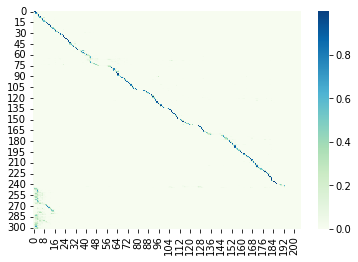

Validation Loss:  tensor(8.3299, device='cuda:0')
Validation Distance:  19.33025678294574
Teacher forcing rate 0.5599999999999999
[1.5625e-05]
Epoch:  61


  0%|          | 0/446 [00:00<?, ?it/s]

Training Loss:  tensor(0.6232, device='cuda:0')


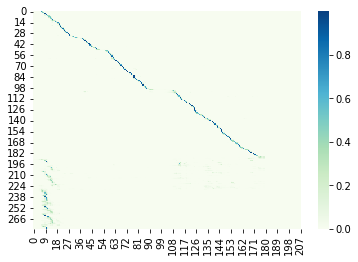

Validation Loss:  tensor(8.3103, device='cuda:0')
Validation Distance:  18.03735465116279
Teacher forcing rate 0.5299999999999999
[1.5625e-05]
Epoch:  62


  0%|          | 0/446 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(epoch, n_epochs):
    print('Epoch: ', epoch+1)
    
    train(epoch, model, train_loader, criterion, optimizer, 'train')
    distance = val(model, val_loader)

    print('Teacher forcing rate', teacherForcing)

    if distance < 20:
        scheduler.step(distance)
        print(scheduler._last_lr)
        if teacherForcing > 0.3:
            teacherForcing -= 0.03
            prev_distance = distance

    elif distance <= 50 and distance >= 20:
        teacherForcing -= 0.05

    elif distance >= 50 and distance <= 100:
        teacherForcing = 0.9

    if epoch >= 10 and epoch % 5 == 0:
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_sched': scheduler
        }
        torch.save(checkpoint, './checkpoint'+str(epoch)+'.pth')

In [ ]:
batch_size = 32

root = '/content/hw4p2_student_data/hw4p2_student_data'

test_data = LibriSamplesTest(root, 'test')
test_loader = DataLoader(test_data, shuffle = False, collate_fn = test_data.collate_fn, batch_size = batch_size)

print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Test dataset samples = 2620, batches = 82


In [ ]:
listOfPredText = []
model.eval()
for i, batch in enumerate(test_loader):
    
    x = batch[0].to(device)
    lx = batch[1]

    predictions, _ = model(x, lx, y, mode = 'test')
    predText = predictions.argmax(-1).detach().cpu().numpy()
    listOfPredText.append(predText)

In [ ]:
def truncate(prediction):
    listOfPredictions = []
    for batch in prediction:
        for i in range(len(batch)):
            pred = batch[i]
            predictionTokens = []
            for token in pred:
                if token == 0:
                    continue
                elif token == 29:
                    break
                else:
                    predictionTokens.append(token)
            predictedString = "".join(transform_index_to_letter(predictionTokens))
            listOfPredictions.append(predictedString)
    return listOfPredictions

In [ ]:
import pandas as pd
df = pd.DataFrame()
predictionText = truncate(listOfPredText)
df['predictions'] = predictionText

In [ ]:
df['id'] = list(range(len(df)))
df=df[['id','predictions']]
df.to_csv('submission.csv', index = False)
! kaggle competitions submit -c 11-785-s22-hw4p2-slack -f /content/submission.csv -m "Message"